 <font size = +3.5><b><u><center> Phase 2 Project Notebook </center></u></b></font>

# Business Understanding

 * As a Construction Consulting firm, Royal Advisory helps new home renovation businesses establish themselves in the Seattle market.
 <br>  
  
  * With the housing market is cooling rapidly in Seattle, homeowners are increasingly opting to invest in remodeling their current home instead of buying new properties. Given this [increase in demand](https://www.king5.com/article/money/markets/real-estate/seattle-home-renovation-housing-cooldown/281-71cb28a8-1bd5-4187-955f-debad072fe53), now is the perfect time for a home renovation company to move into the Seattle area. 
  <br>  
  
  * A new home renovation company, Home Remedies, hired us to recommend the best services to offer to clients looking to increase the sale value of their homes. 
 <br>

## Types of Remodeling Projects

 * First, based on [industry definitions](https://www.homeadvisor.com/cost/additions-and-remodels/), we identifed three major components of home remodeling projects:
     1. **Home Renovations:** Updating the quality of the house's building material
     2. **Home Remodeling:** Increasing the size of your home, either through extensions or additions:
         2a. **Home Extensions:** Increasing the size of existing section of the house
         2b. **Home Additions:** Adding a new section to your home
     
 * We were then guided by these business questions:

## Business Questions: 

1. For all clients interested in home remodeling (increasing the area of your house, either through *home extensions* or *home additions*, where are the best areas to add square footage?
    - Which areas of the house is increased area associated with increased sale value?
    - Our model included these common home spaces: Above-Ground Living Space (e.g. rooms, kitchen, hallways), Basement, Garage, Patio, Yard

<br> 

2. For clients specifically interested in *home additions*, what are the best structures to add to increase the sale value of their house?
    - What types of home additions contribute to a higher sale price?
    
<br>  
    
3. How much do renovations contribute to the sale price of a house? Should clients add build quality renovation projects to their home remodeling projects to increase their house's value?
<br>  

***

## Data Source & Relevance to Business Case

<font color = green><b><u> Rubric: Data Understanding pt 1 </u></b>
    
1. Describe the data sources and explain why the data are suitable for the project
2. Present the size of the dataset </font>

* Data from King County: all house sale in 2021 (n = 30155)

* Current data allows us to see what *features of a house* contributed to house sale price in 2021
   * From this, we can infer what types of house changes could increase future house sale price

# Data Preparation

<font color = green><b><u> Rubric: Data Preparation </u></b></font>

1. Instructions or code needed to get and prepare the raw data for analysis
2. Code comments and text to explain what your data preparation code does
3. Valid justifications for why the steps you took are appropriate for the problem you are solving

## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
# Collect entire data 

data = pd.read_csv('data/kc_house_data.csv')

## Exploring Variables in Dataset

In [3]:
# Checkout all data columns & spot Null values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Identifying Features of Interest to Answer Current Questions

<font color = green><b><u> Rubric: Data Understanding pt2 </u></b>
    
2. descriptive statistics for all features used in the analysis
3. Justify the inclusion of features based on their properties and relevance for the project </font>

### Features of Interest based on Questions:

 * **Remodeling** *(increasing area of house, either by extending existing space or adding new space)*:
    1. Living Space (Total Living Space: Space physically within the "house")
        * Above-Ground Living Space (sqft_above)
        * Basement (sqft_basement)
    2. Garage Space (sqft_garage)
    3. Patio Space (sqft_patio)
    4. Yard Space (sqft_yard; will calculate from given variables)  
    
    
 * **Addition** *(adding a new room/section to house)*:
    1. Number of Bathrooms
    2. Number of Bedrooms
    3. Has Garage (binary calculated from sqft_garage: yes/no)
    4. Has Patio (binary calculated from sqft_patio: yes/no)
    

 * **Renovation** *(upgrading building quality)*:
    1. Grade


### Columns to Exclude

* First, we excluded variables that a home remodeling company *could not change* -- not useful information for our client
* Second, we excluded the "Condition and sqft_living" variable
    * King County Definition: "Condition is relative to age and grade"
        * Would repeat the effect of one of our key variables (grade)
        * Since grade refers to "construction build and quality," it is more relevant to our client
* Third, we excluded Heat Source & Sewer System variables because they are outside of the scope of the services Home Remedies can offer. Home Remedies generally refers clients who are interested in such projects to external Energy Consultants or Plumbers.

<font color = blue> <b> Move to Conclusion Section: </b>
    <br>  
    * Some of these variables could account for price valuation (such as location) <br>  
    * In future analyses, we could improve our models by including some of these as control variables </font>

In [4]:
# Dropping columns not related to current questions/analyses

df = data.drop(['id', 'date', 'view', 'waterfront', 'greenbelt', 'nuisance',
                'condition', 'yr_built','yr_renovated', 'heat_source', 'sewer_system','address', 'lat', 'long'], axis=1)

### Calculating Features of Interest not yet present in dataset

Yard Space: calculating based on [architect definitions](https://www.yourownarchitect.com/what-is-the-difference-between-floor-area-and-lot-area/) and [Seattle permit regulations](https://www.seattle.gov/DPD/Publications/CAM/cam220.pdf)

Yard Space = Lot Space - Ground Floor Living Space

We can estimate this by dividing the above ground living space by the number of floors 

In [5]:
df['sqft_yard'] = df['sqft_lot'] - ((df['sqft_above']/round(df['floors'])))

#There are 15 entries where yard space is negative. Since this is impossible, we will replace these values with 0.
df['sqft_yard'].mask(df['sqft_yard']<0, 0, inplace=True)

df['sqft_yard'].describe()

count    3.015500e+04
mean     1.552185e+04
std      6.030965e+04
min      0.000000e+00
25%      3.692500e+03
50%      6.220000e+03
75%      9.232500e+03
max      3.253082e+06
Name: sqft_yard, dtype: float64

We can now drop floors and sqft_lot from our dataset, since we do not use them further:

In [6]:
df.drop(['floors', 'sqft_lot'], axis=1, inplace=True)

Presence of Basement/Garage/Patio: binary variables (Y/N)

* For the house additions analysis, we want to compare houses that have these features compared to houses that do not. 
For garage and patio, we need to derive this information from the sq_ft variable:

In [7]:
# Changing basement, patio, and garage to binary
# 1 (YES) the property has one or 0 (NO) the property does not have one

df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
df['has_garage'] = df['sqft_garage'].apply(lambda x: 1 if x > 0 else 0)
df['has_patio'] = df['sqft_patio'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'sqft_yard',
       'has_basement', 'has_garage', 'has_patio'],
      dtype='object')

## Cleaning Variables

In [9]:
#For graph visibility, making Grade into a new, numeric-only variable (grade_num)

orig_grade_val = list(df['grade'].value_counts().sort_index(ascending=False).index)
orig_grade_val
new_grade_val = [9, 8, 7, 6, 5, 4, 3, 2, 13, 12, 11, 10, 1]

df['grade_num'] = df['grade'].replace(orig_grade_val, new_grade_val)

In [10]:
# Might be helpful to have a grade_dict matching num to definition

grade_dict = {new_grade_val[i]: orig_grade_val[i].strip('0123456789.- ') for i in range(len(new_grade_val))}

grade_dict
df['grade'] = df['grade_num']

In [11]:
df.drop('grade_num', axis=1, inplace=True)

## Initial Descriptive Statistics

In [12]:
df.describe(include='all')

,price,bedrooms,bathrooms,sqft_living,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,sqft_yard,has_basement,has_garage,has_patio
count,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000
mean,1.108536e+06,3.413530,2.334737,2112.424739,7.651368,1809.826098,476.039396,330.211142,217.412038,1.552185e+04,0.486951,0.668082,0.775825
std,8.963857e+05,0.981612,0.889556,974.044318,1.148978,878.306131,579.631302,285.770536,245.302792,6.030965e+04,0.499838,0.470910,0.417045
min,2.736000e+04,0.000000,0.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,6.480000e+05,3.000000,2.000000,1420.000000,7.000000,1180.000000,0.000000,0.000000,40.000000,3.692500e+03,0.000000,0.000000,1.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,8.000000,1560.000000,0.000000,400.000000,150.000000,6.220000e+03,0.000000,1.000000,1.000000
75%,1.300000e+06,4.000000,3.000000,2619.500000,8.000000,2270.000000,940.000000,510.000000,320.000000,9.232500e+03,1.000000,1.000000,1.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,13.000000,12660.000000,8020.000000,3580.000000,4370.000000,3.253082e+06,1.000000,1.000000,1.000000


**Variable Breakdown:**

**Outcome:** price <br>
**Categorical (Ordinal) Variables:** bedrooms, bathrooms, grade <br>
**Binary Variables:** has_garage, has_patio <br>
**Continuous Variables:** sqft_living, sqft_above, sqft_basement, sqft_garage, sqft_patio, sqft_yard

### Categorical Variables

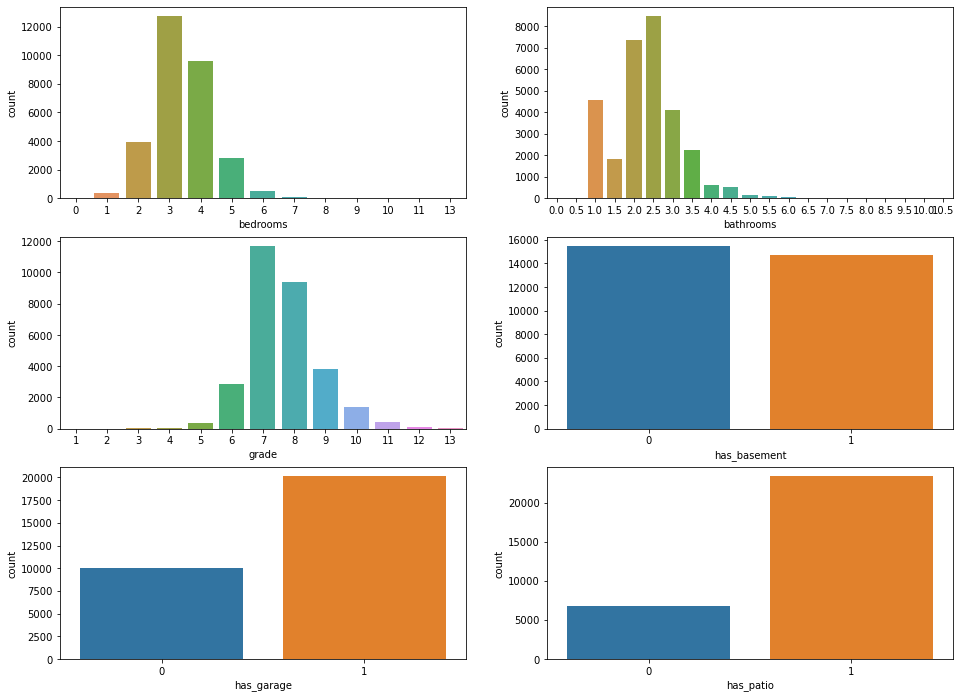

In [13]:
cat = ['bedrooms', 'bathrooms', 'grade', 'has_basement','has_garage', 'has_patio']
df_cat = df[cat] 

fig, ax = plt.subplots(3, 2, figsize=(16,12))

for i, col in enumerate(df_cat.columns):
    x = i//2
    y = i%2
    sns.countplot(x=col, data=df_cat, ax=ax[x][y])

* Outliers in Bedrooms, Bathrooms, Grade -- need to exclude or combine categories

* Similar amount of houses that have basements compared to ones that do not

* Greater number of houses that have a garage or have a patio compared to ones that do not

### Continuous Variables (Outcome + Predictors)

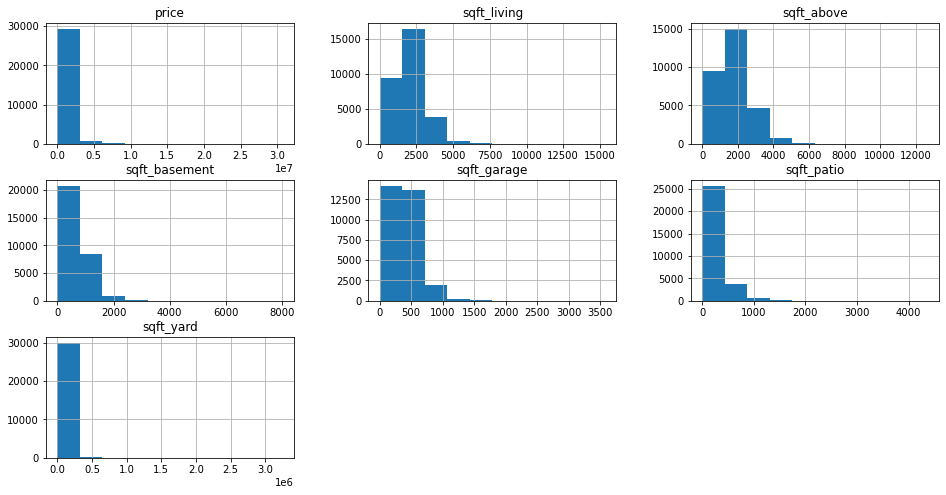

In [14]:
cont = ['price', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio','sqft_yard']

df[cont].hist(figsize=(16,8));

* All of these variables are heavily skewed right

* Options to consider:
1. Removing outliers
2. Transforming data

## Defining & Excluding Outliers

* We want to look at typical qualities of houses: only cases relevant to our client
    * Data indicates many outliers: 
        * Rare to encounter clients with houses fitting these cases
        * Even so, clients within the outliers are likely to have different goals/priorities than target audience

### Categorical Ordinal Variables: Dropping Outliers

* For all categorical ordinal variables (Bathroom, Bedroom, Floors, Grade): we excluded any group with n < 100.

In [15]:
df['bedrooms'].value_counts()

df = df[(df['bedrooms'] != 0) & (df['bedrooms'] < 7)]

df['bedrooms'].value_counts().sort_index()

1      391
2     3936
3    12754
4     9597
5     2798
6      498
Name: bedrooms, dtype: int64

In [16]:
df['bathrooms'].value_counts()

df = df[(df['bathrooms'] >= 1) & (df['bathrooms'] <= 5)]

df['bathrooms'].value_counts().sort_index()

1.0    4560
1.5    1807
2.0    7341
2.5    8470
3.0    4083
3.5    2256
4.0     616
4.5     518
5.0     135
Name: bathrooms, dtype: int64

In [17]:
df['grade'].value_counts() 
# Based on n < 100 rule, can exclude 1, 2, 3, 4, 12, 13

df = df[(df['grade'] > 4) & (df['grade'] < 12)]

df['grade'].value_counts().sort_index()


5       386
6      2847
7     11623
8      9339
9      3776
10     1300
11      361
Name: grade, dtype: int64

#### Condensing grade into 4 categories

After reviewing the King County definitions, we decided to combine similar grades into 4 categories, based on the similar language that each definition used. For the categories labeled as "High Quality," we used the label "Exceptional"

 * 5 & 6 = Below Average
 * 7 = Average
 * 8 & 9 = Above Average
 * 10 & 11 = Exceptional Quality
 

In [18]:
grade_old = [5,6,7,8,9,10,11]
grade_new = ['Below_Average', 'Below_Average', 'Average', 'Above_Average', 'Above_Average', 'Exceptional', 'Exceptional']

df['grade'] = df['grade'].replace(grade_old, grade_new)

df['grade'].value_counts()

df['grade']=pd.Categorical(df['grade'], ordered=True, categories=['Below_Average', 'Average', 'Above_Average','Exceptional'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29632 entries, 0 to 30154
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          29632 non-null  float64 
 1   bedrooms       29632 non-null  int64   
 2   bathrooms      29632 non-null  float64 
 3   sqft_living    29632 non-null  int64   
 4   grade          29632 non-null  category
 5   sqft_above     29632 non-null  int64   
 6   sqft_basement  29632 non-null  int64   
 7   sqft_garage    29632 non-null  int64   
 8   sqft_patio     29632 non-null  int64   
 9   sqft_yard      29632 non-null  float64 
 10  has_basement   29632 non-null  int64   
 11  has_garage     29632 non-null  int64   
 12  has_patio      29632 non-null  int64   
dtypes: category(1), float64(3), int64(9)
memory usage: 3.0 MB


### Continuous Variables: Dropping Outliers

* Outcome variable: Price 
* Continuous predictors: sqft_living, sqft_above, sqft_basement, sqft_garage, sqft_patio, sqft_yard

* Two options for outlier removal:
1. IQR Method: (Lower, Upper) = (Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR)
2. Z Method: (Lower, Upper) = (z = -3), (z = 3)

* Because each variable is heavily skewed right, both options ended up removing >10% data from various columns

* We created functions to test what percent of data will be removed through each outlier method, and whether to proceed/try a new method:

#### Z Method: Percentage of Data to Remove Function

In [19]:
def z_method(orig_len, ref_df, cols):
    test_df = ref_df
    outliers_removed = []
    outliers_not_removed = []
    percent = (orig_len - len(ref_df))/orig_len*100
    
    for col in cols:
        test_df = ref_df[(ref_df[col] > np.percentile(ref_df[col], .25)) & (ref_df[col] < np.percentile(ref_df[col], 99.75))]
        percent_new_data = (orig_len-len(test_df))/orig_len*100
        
        if percent_new_data < 10:
            outliers_removed.append(col)
            ref_df = test_df
            percent = percent_new_data
        else:
            outliers_not_removed.append(col)
    
    print(f"Outliers were removed from {outliers_removed}, excluding {percent:.2f}% of the total data.")
    print(f"These columns still include outliers: {outliers_not_removed}.")
    print(f"Clean dataset: n = {len(ref_df)}")
    
    return ref_df, outliers_removed, outliers_not_removed


#### IQR Method: Percentage of Data to Remove Function

In [20]:
def iqr_method(orig_len, ref_df, cols):
    outliers_removed = []
    outliers_not_removed = []
    test_df = ref_df
    percent_sum = (orig_len - len(ref_df))/len(data)*100
    
    for col in cols:
        q1 = np.percentile(ref_df[col], [25])
        q3 = np.percentile(ref_df[col], [75])
        three_halves_iqr = 1.5*(q3 - q1)
        lower = int(q1 - three_halves_iqr)
        upper = int(q3 + three_halves_iqr)
        
        test_df = ref_df[(ref_df[col] < upper) & (ref_df[col] > lower)]
        percent_new_data = (orig_len-len(test_df))/orig_len*100
        
        if percent_new_data < 10:
            outliers_removed.append(col)
            ref_df = test_df
            percent = percent_new_data
        else:
            outliers_not_removed.append(col)
    
    print(f"Outliers were removed from {outliers_removed}, excluding {percent:.2f}% of the total data.")
    print(f"These columns still include outliers: {outliers_not_removed}.")
    print(f"Clean dataset: n = {len(ref_df)}")
    
    return ref_df, outliers_removed, outliers_not_removed

### Implementing Methods

In [21]:
cols = ['price', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'sqft_yard']

z_remove_outliers = z_method(len(data), df, cols)

df_new = z_remove_outliers[0]
removed_cols = z_remove_outliers[1]
not_removed_cols = z_remove_outliers[2]

Outliers were removed from ['price', 'sqft_living', 'sqft_above', 'sqft_yard'], excluding 3.72% of the total data.
These columns still include outliers: ['sqft_basement', 'sqft_garage', 'sqft_patio'].
Clean dataset: n = 29034


In [22]:
iqr_remove_outliers = iqr_method(len(data), df_new, not_removed_cols)

df_new_2 = iqr_remove_outliers[0]
removed_cols_2 = iqr_remove_outliers[1]
not_removed_cols_2 = iqr_remove_outliers[2]

Outliers were removed from ['sqft_basement', 'sqft_garage', 'sqft_patio'], excluding 7.66% of the total data.
These columns still include outliers: [].
Clean dataset: n = 27846


* Through this combination of the z-method and IQR-method, we were able to remove outliers from all of our continuous variables and drop less than 10% of our data!

* Setting df_new_2 as df:

In [23]:
df = df_new_2

len(df)

27846

## Descriptive Statistics of Cleaned Variables

In [24]:
df.describe(include='all')

,price,bedrooms,bathrooms,sqft_living,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,sqft_yard,has_basement,has_garage,has_patio
count,2.784600e+04,27846.000000,27846.000000,27846.000000,27846,27846.000000,27846.000000,27846.000000,27846.000000,27846.000000,27846.000000,27846.000000,27846.000000
unique,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,Above_Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,12284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.028063e+06,3.383502,2.276377,2026.604324,NaN,1744.076169,454.187172,317.551067,181.311140,11438.220002,0.482475,0.669216,0.766142
std,6.125785e+05,0.902612,0.798184,818.101903,NaN,765.973727,539.920571,263.019066,174.638677,28550.650025,0.499702,0.470504,0.423290
min,9.620500e+04,1.000000,1.000000,600.000000,NaN,610.000000,0.000000,0.000000,0.000000,157.333333,0.000000,0.000000,0.000000
25%,6.399992e+05,3.000000,2.000000,1400.000000,NaN,1170.000000,0.000000,0.000000,40.000000,3575.250000,0.000000,0.000000,1.000000
50%,8.499990e+05,3.000000,2.500000,1880.000000,NaN,1530.000000,0.000000,390.000000,140.000000,6060.000000,0.000000,1.000000,1.000000
75%,1.250000e+06,4.000000,2.500000,2520.000000,NaN,2190.000000,920.000000,500.000000,290.000000,8694.000000,1.000000,1.000000,1.000000


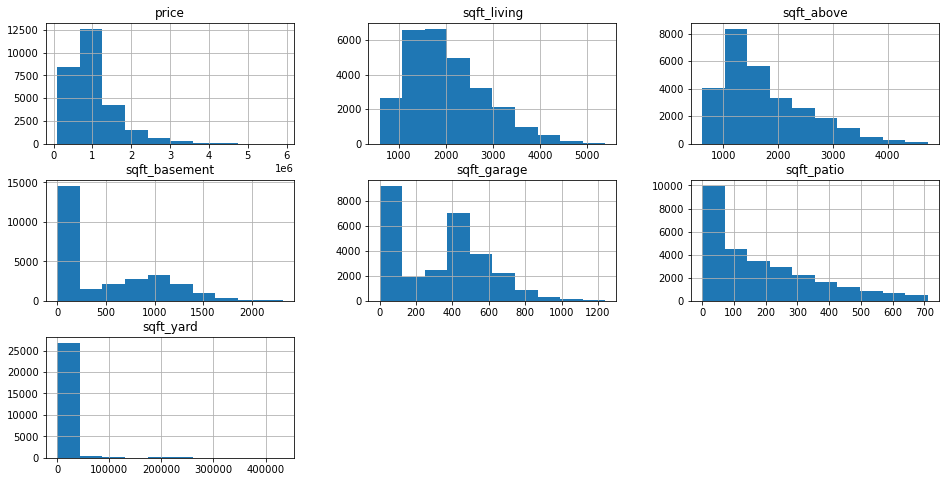

In [25]:
df[cols].hist(figsize=(16,8));

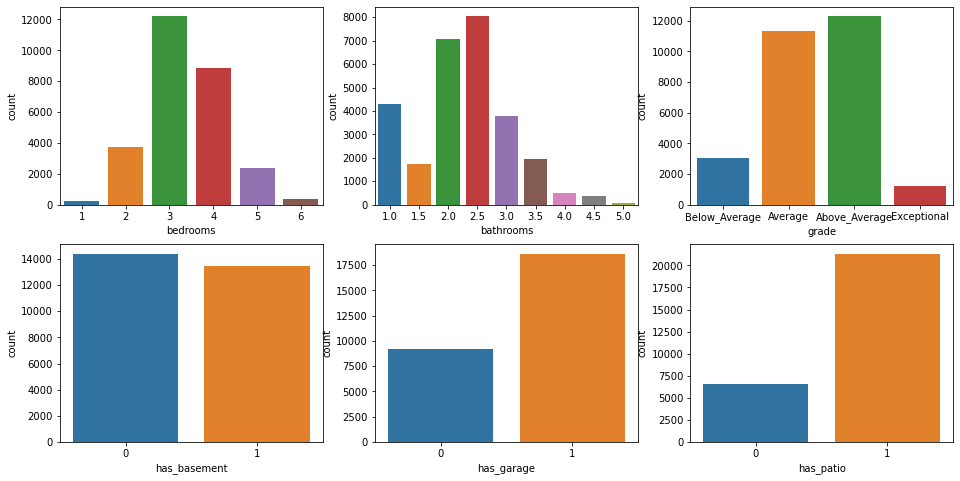

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))

for i, col in enumerate(df_cat.columns):
    x = i//3
    y = i%3
    sns.countplot(x=col, data=df, ax=ax[x][y])

# Initial Visualization

## Pair Plots - Price and X Variables

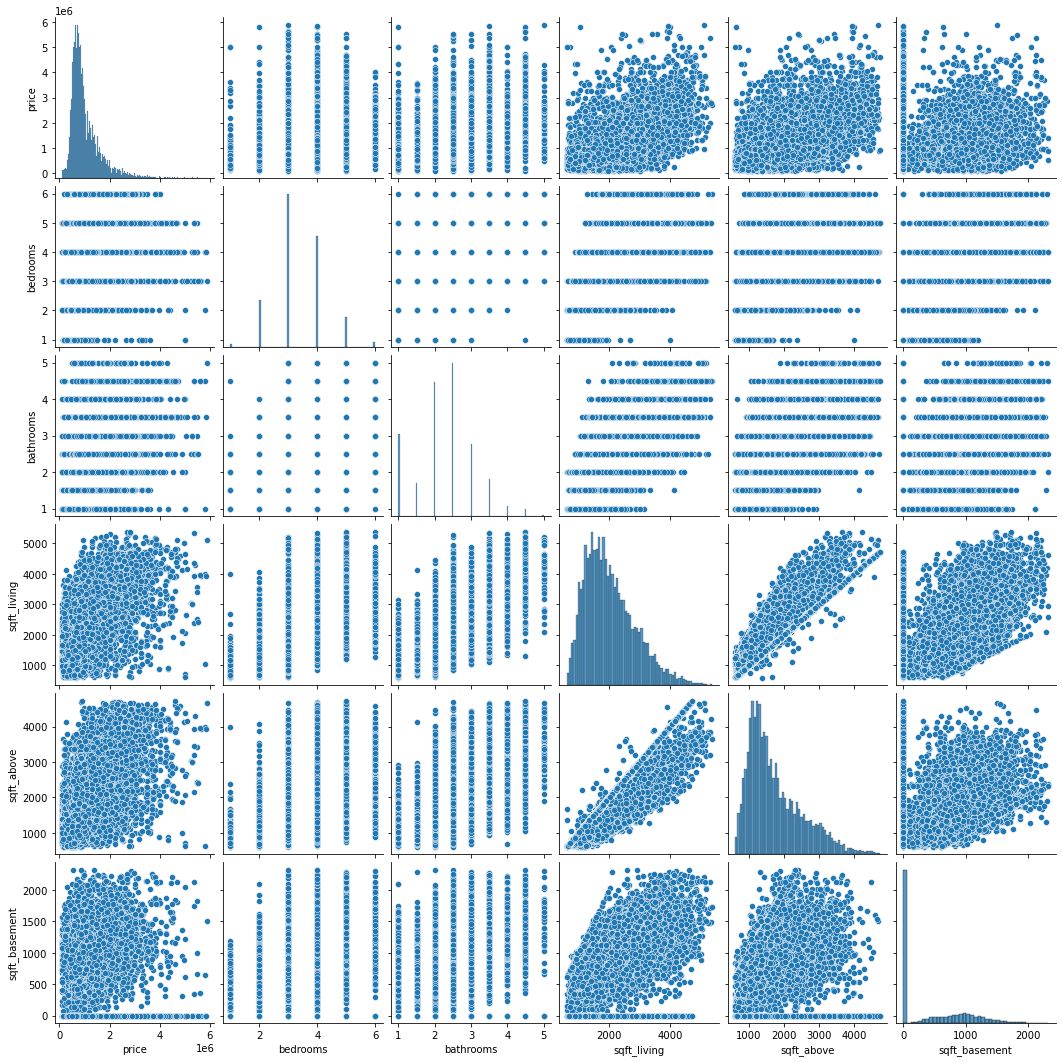

In [27]:
# Pair Plot Part 1

sns.pairplot(df.iloc[:,0:7]);

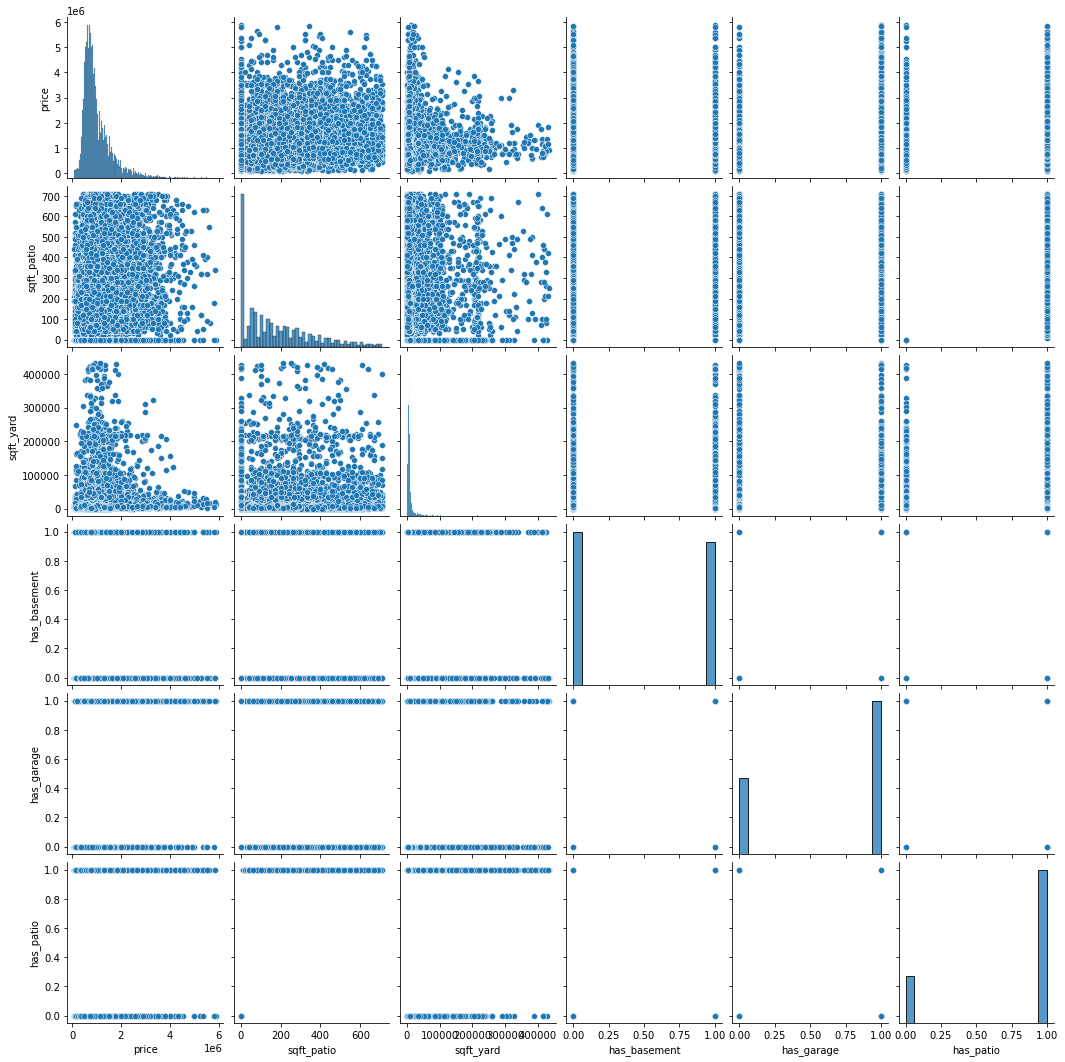

In [28]:
group2 = [0, 8, 9, 10, 11, 12]

sns.pairplot(df.iloc[:,group2]);

## Heat Map

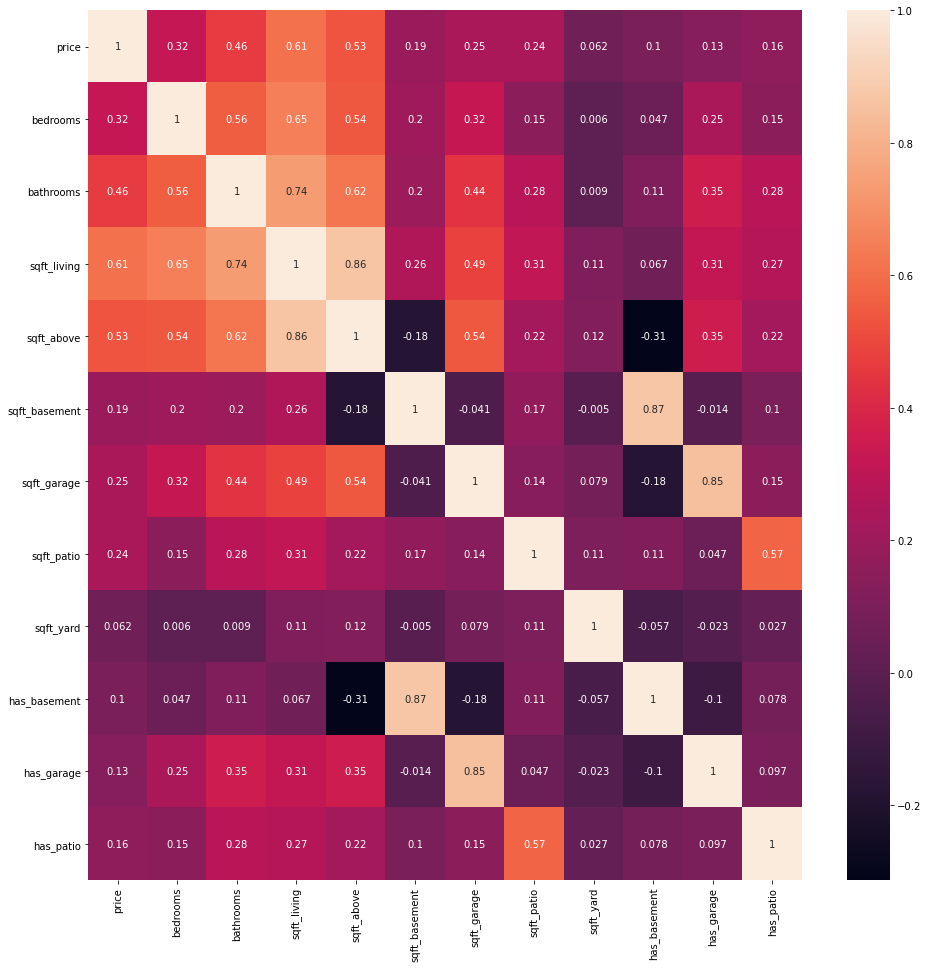

In [29]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot = True);

### Notes/Interpretations:

1. Relationships look murky: perhaps because most of the variables we are working with have wide, not normal distributions.

2. Highest correlation with price: sqft_above (r = 0.53), bathrooms (r = 0.47), bedrooms (r = 0.32)
* Not very promising r-values <br>
3. Possibility of multicollinearity: should be aware of that as we run & interpret model

# Baseline Model & Testing Assumptions

**Rubric**

Runs and interprets a simple, baseline model for comparison

Introduces new models that improve on prior models and interprets their results

Explicitly justifies model changes based on the results of prior models and the problem context

Explicitly describes any improvements found from running new models

For our baseline model, we decided to use sqft_above:
   * Highest correlation on heatmap
   * We can build on it to answer Question 1: which home locations are associated with increased sale value?

## Baseline Model (Price based on Sq. Ft Above)

In [30]:
Y = df['price']
X_base = sm.add_constant(df['sqft_above'])

model_base = sm.OLS(Y1,X_base).fit()
model_base.summary()

NameError: name 'Y1' is not defined

1. The model only explains 28% of the variance in sale price (R2 = 0.28), which is small.

2. We need to test the assumptions of linear regression. It is highly likely our model fails these assumptions
 - High Condition Number, Kurtosis, Significant Omnibus, Durbin-Watson < 2 
 
* After building our full model, we will test the assumptions of linear regression and apply transformations as needed.

# Model 1: Building Multiple Linear Regression Model Iteratively

**Question we are trying to answer:**
For which home areas is *increased size* associated with *higher sale value?*
Which section of the house has the greatest positive relationship with sale value?

Y: price

X:  
sqft_above <br>
sqft_basement <br>
sqft_garage <br>
sqft_patio <br>
sqft_yard <br> 

(4 iterations: add basement, add garage, add patio, add yard)

### Iteration #1: Adding sqft_basement

In [32]:
Y = df['price']
var = ['sqft_above', 'sqft_basement']
X1 = sm.add_constant(df[var])

model1 = sm.OLS(Y,X1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     8037.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:41:42   Log-Likelihood:            -4.0423e+05
No. Observations:               27846   AIC:                         8.085e+05
Df Residuals:                   27843   BIC:                         8.085e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.165e+04   8163.638      7.552      0.000    4.56e+04    7.77e+04
sqft_above      466.0852      3.879    120.147      0.000     458.482     473.689
sqft_basement   338.0195      5.503     61.419      0.000     327.232     348.807
==============================================================================
Omnibus:                    11938.201   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108680.806
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                      11.962   Cond. No.                     5.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* R2 = 0.371: better but not great
* Still problems with linear assumptions

### Iteration #2: Adding sqft_ Garage

In [33]:
Y = df['price']
var.append('sqft_garage')
X2 = sm.add_constant(df[var])

model2 = sm.OLS(Y,X2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     5467.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:41:46   Log-Likelihood:            -4.0412e+05
No. Observations:               27846   AIC:                         8.083e+05
Df Residuals:                   27842   BIC:                         8.083e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.689e+04   8140.410      6.988      0.000    4.09e+04    7.28e+04
sqft_above      501.9396      4.600    109.115      0.000     492.923     510.956
sqft_basement   343.3740      5.496     62.478      0.000     332.602     354.146
sqft_garage    -189.5823     13.190    -14.374      0.000    -215.435    -163.730
==============================================================================
Omnibus:                    11865.330   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108493.334
Skew:                           1.812   Prob(JB):                         0.00
Kurtosis:                      11.965   Cond. No.                     5.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Iteration #3: Adding sqft_patio

In [34]:
var.append('sqft_patio')
X3 = sm.add_constant(df[var])

model3 = sm.OLS(Y,X3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     4183.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:41:49   Log-Likelihood:            -4.0402e+05
No. Observations:               27846   AIC:                         8.080e+05
Df Residuals:                   27841   BIC:                         8.081e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.488e+04   8152.729      5.505      0.000    2.89e+04    6.09e+04
sqft_above      487.5223      4.690    103.938      0.000     478.329     496.716
sqft_basement   325.9686      5.607     58.141      0.000     314.979     336.958
sqft_garage    -191.5147     13.141    -14.573      0.000    -217.273    -165.757
sqft_patio      251.8989     17.440     14.443      0.000     217.715     286.083
==============================================================================
Omnibus:                    11894.913   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110401.704
Skew:                           1.812   Prob(JB):                         0.00
Kurtosis:                      12.056   Cond. No.                     5.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Iteration 4: sqft_yard

In [35]:
var.append('sqft_yard')
X4 = sm.add_constant(df[var])

model4 = sm.OLS(Y,X4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     3348.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:41:52   Log-Likelihood:            -4.0402e+05
No. Observations:               27846   AIC:                         8.080e+05
Df Residuals:                   27840   BIC:                         8.081e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.545e+04   8156.118      5.573      0.000    2.95e+04    6.14e+04
sqft_above      488.2918      4.703    103.832      0.000     479.074     497.509
sqft_basement   325.9376      5.606     58.139      0.000     314.949     336.926
sqft_garage    -191.0429     13.142    -14.537      0.000    -216.802    -165.284
sqft_patio      255.1243     17.498     14.580      0.000     220.827     289.422
sqft_yard        -0.2302      0.103     -2.241      0.025      -0.432      -0.029
==============================================================================
Omnibus:                    11911.812   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110797.403
Skew:                           1.815   Prob(JB):                         0.00
Kurtosis:                      12.073   Cond. No.                     8.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing Assumptions of Linear Regression

### Assumption 1: Linearity

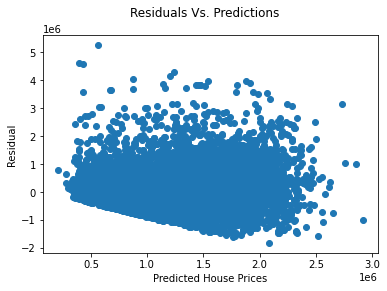

In [36]:
model_preds = model4.predict(X4)
resids = Y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('Predicted House Prices')
ax.set_ylabel('Residual')
plt.suptitle('Residuals Vs. Predictions');

**Fails Assumption 1**
 * No clear linear pattern in graph above

### Assumption 2: Errors are Independent

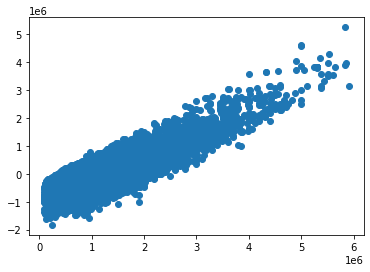

In [37]:
fig, ax = plt.subplots()

ax.scatter(Y, resids);

In [38]:
#Confirming wtih durbin-watson

dw = sm.stats.stattools.durbin_watson

dw(resids)

print(f"{dw(resids):.2f} is less than 2, suggesting positive autocorrelation")

1.93 is less than 2, suggesting positive autocorrelation


**Fails Assumption 2**

* Errors are not independent
* Errors seem to have a linear pattern

### Assumption 3: Errors are Normally Distributed

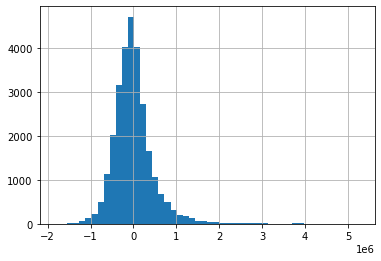

In [39]:
# Histogram of residuals

resids.hist(bins=50);

* Slight skew right

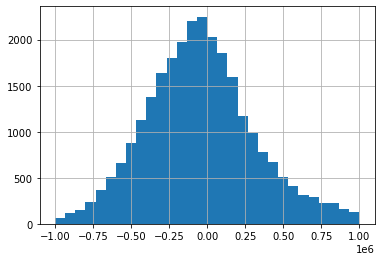

In [40]:
# Residuals histogram without outliers

resids[abs(resids) < 1e6].hist(bins=30);

* Normal-ish pattern with a slight skew right

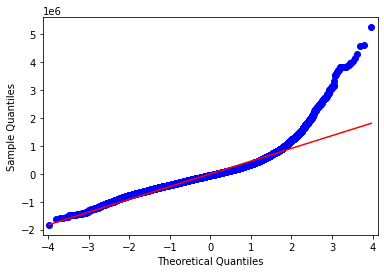

In [41]:
sm.qqplot(resids, line='r');

* Highly Positively Skewed (1.846 > 1)
* significant omnibus test & Jarque-Bera test (p < 0.001).
* Kurtotic (10.815 > 3)

In [42]:
model1.summary().tables[2]

Omnibus:,11938.201,Durbin-Watson:,1.929
Prob(Omnibus):,0.000,Jarque-Bera (JB):,108680.806
Skew:,1.827,Prob(JB):,0.00
Kurtosis:,11.962,Cond. No.,5.43e+03


**Fails Assumption 3**
* Errors are not normally distributed

### Assumption 4: Homoskedasticity

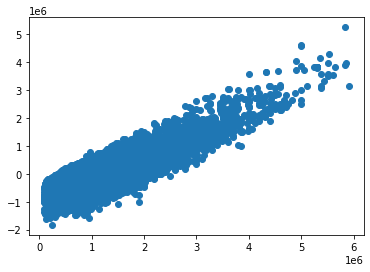

In [43]:
# Residuals graph kind of peters out towards top, which could indicate homoskedasticity

fig, ax = plt.subplots()

ax.scatter(Y, resids);

In [44]:
# Test with Breusch-Pagan and Goldfeld-Quandt

p_breusch_pagan = sm.stats.diagnostic.het_breuschpagan(resids, X1)[1]
print(p_breusch_pagan)

if (p_breusch_pagan < 0.05):
    print("Reject null hypothesis (data is not homoskedastic)")


0.0
Reject null hypothesis (data is not homoskedastic)


**Fails Assumption 4**
* Data fails the assumption of homoskedasticity

### Assumption 5: Multicollinearity

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X4.columns

vif_data["VIF"] = [variance_inflation_factor(X4.values, i)
                          for i in range(len(X4.columns))]

vif_data

,feature,VIF
0,const,7.902867
1,sqft_above,1.541439
2,sqft_basement,1.088417
3,sqft_garage,1.419427
4,sqft_patio,1.109369
5,sqft_yard,1.021868


* VIF < 5, which is in the acceptable range to assume lack of multicollinearity.

## Failed Assumptions: Transformation

* Failed tests 1-4

* We will try transforming the data to fix issues with the linear regression assumptions

* Heavy right skew: options = log transformation, square root, box cox

### Trying Transformation:

#### Options: Box Cox or Square Root

* Data that is skewed right is most helped by *square root,* *cube root,* or *log transformations*
* Ideally, we should use the same transformation on all of our continuous variables so that coefficients are comparable.

* Cannot use log with zero-value variables
* Sq_rt = possible 


Let's try square root first since that is easier:

In [48]:
y_sqrt_trf = np.sqrt(df['price'])
x4_sqrt_trf = np.sqrt(df[var])
x4_sqrt_trf = sm.add_constant(x4_sqrt_trf)

model_4_trf = sm.OLS(y_sqrt_trf,x4_sqrt_trf).fit()
model_4_trf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3423.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:42:54   Log-Likelihood:            -1.8838e+05
No. Observations:               27846   AIC:                         3.768e+05
Df Residuals:                   27840   BIC:                         3.768e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           129.9705      6.771     19.196      0.000     116.700     143.241
sqft_above       19.0147      0.177    107.676      0.000      18.669      19.361
sqft_basement     5.2612      0.085     61.940      0.000       5.095       5.428
sqft_garage      -1.8658      0.136    -13.734      0.000      -2.132      -1.600
sqft_patio        2.0746      0.174     11.950      0.000       1.734       2.415
sqft_yard        -0.0069      0.021     -0.331      0.741      -0.047       0.034
==============================================================================
Omnibus:                     3667.250   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11244.433
Skew:                           0.693   Prob(JB):                         0.00
Kurtosis:                       5.787   Cond. No.                         616.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
* R2 = 0.38. 
* We can drop sqft_yard since insignificant effect on model (p > 0.05)

*Lower condition number, skew is normal, kurtosis is better
*Still significant omnibus & JB (data): errors are not normally distributed
*Durbin-Watson still under 2, positive autocorrelation

In [50]:
var.remove('sqft_yard')

y_sqrt_trf = np.sqrt(df['price'])
x4b_sqrt_trf = np.sqrt(df[var])
x4b_sqrt_trf = sm.add_constant(x4b_sqrt_trf)

model_4b_trf = sm.OLS(y_sqrt_trf,x4b_sqrt_trf).fit()
model_4b_trf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     4279.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:43:18   Log-Likelihood:            -1.8838e+05
No. Observations:               27846   AIC:                         3.768e+05
Df Residuals:                   27841   BIC:                         3.768e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           129.7253      6.730     19.276      0.000     116.534     142.916
sqft_above       19.0073      0.175    108.494      0.000      18.664      19.351
sqft_basement     5.2616      0.085     61.950      0.000       5.095       5.428
sqft_garage      -1.8670      0.136    -13.747      0.000      -2.133      -1.601
sqft_patio        2.0707      0.173     11.955      0.000       1.731       2.410
==============================================================================
Omnibus:                     3662.003   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11222.529
Skew:                           0.692   Prob(JB):                         0.00
Kurtosis:                       5.785   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Results

Explicitly identify the features and interpret their coefficients in plain language

Explain the implications of results for the real-world problem the project aims to address

Identify specific actions that stakeholders should take to leverage these results
